In [1]:
import pandas as pd
import numpy as np
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.proportion import proportions_ztest
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus=False) # 음수표시
warnings.filterwarnings('ignore') # 경고메시지 출력 제외
import scipy.stats as stats
from sklearn.model_selection import train_test_split # 데이터 분할
from statsmodels.api import qqplot, add_constant # qqplot, 회귀분석의 상수항 추가
import statsmodels.formula.api as smf # 선형 모델
from statsmodels.tools.eval_measures import rmse # 평가 함수
from sklearn.metrics import r2_score # 결정계수 평가지표
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성

# BAD: 대출금 상환 여부, 0은 상환, 1은 미상환
# LOAN: 대출금액($)
# MORTDUE: 저당금액($)
# VALUE: 현 재의 자산가치($)
# REASON: 대출사유, Homelmp(주택개량), 빚정리(debtcon), 기타(Other)
# JOB: 직업의종류(7가지)
# YOJ: 현재 직장에서의 근무년수(Year)
# DEROG: 불량사유보고횟수
# DELINQ: 신용한도
# CLAGE: 계좌유지 기간
# NINQ: 최근의 신용상태 조사수
# CLNO: 금융거래의 수
# DEBTINC: 수입에 대한 부채비율(%)

In [2]:
df = pd.read_csv('data\\bank.csv')

In [3]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3748 non-null   int64  
 1   LOAN     3748 non-null   int64  
 2   MORTDUE  3748 non-null   int64  
 3   VALUE    3734 non-null   float64
 4   REASON   3748 non-null   object 
 5   JOB      3667 non-null   object 
 6   YOJ      3543 non-null   float64
 7   DEROG    3748 non-null   int64  
 8   DELINQ   3718 non-null   float64
 9   CLAGE    3711 non-null   float64
 10  NINQ     3692 non-null   float64
 11  CLNO     3748 non-null   int64  
 12  DEBTINC  3748 non-null   float64
dtypes: float64(6), int64(5), object(2)
memory usage: 380.8+ KB


In [5]:
df.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
# VALUE 결측치 14개
# 결측값을 평균값으로 대체하기보단 VALUE의 중위수로 대체

value_median = df['VALUE'].median()
df['VALUE'].fillna(value_median, inplace=True)

In [7]:
# JOB 결측치 81개
# JOB의 결측치를 unknown으로 대치
df['JOB'].fillna('Unknown', inplace=True)

In [8]:
# YOJ 결측치 205개
# YOJ가 현재 직장에서의 근무연수(Year), 대출인이 고용된 연수
# 직업별로 근무연수가 비슷하지 않을까? -> 직업별 YOJ의 평균으로 대치
# YOJ 컬럼의 결측치를 JOB별 YOJ의 평균으로 대치
df['YOJ'] = df.groupby('JOB')['YOJ'].transform(lambda x: x.fillna(x.mean()))

# YOJ 컬럼을 int형으로 형변환
df['YOJ'] = df['YOJ'].astype(int)

In [9]:
 # DELINQ신용한도수 : 대출 신청자의 최근 6개월 동안의 신용카드나 대출 한도를 새로 개설한 횟수 
# 신용한도, 최근신용한도라고 나와있지만 value_count찍어보니깐 하나는 10, 다른하나는 13이라
# 다른 걸 의미하는 것 같아서 구글링.. 다르더라!
# 전부다 최빈값 처리

# DELINQ, NINQ 최빈값 대치
# DELINQ와 NINQ 컬럼의 결측치를 각 컬럼의 최빈값으로 대치
df['DELINQ'].fillna(df['DELINQ'].mode()[0], inplace=True)
df['NINQ'].fillna(df['NINQ'].mode()[0], inplace=True)

In [10]:
# CLAGE 대출인의 가장 오래된 신용 한도의 기간
# 내 모든 신용계좌의 평균 개월수?
# CLAGE의 이상치 하나있는거 (1168값) CLAGE의 평균으로 대체 한 후에
# CLAGE의 결측값을 CLAGE의 평균으로 대체

clage_mean = df['CLAGE'][df['CLAGE'] < 1100].mean()
df.loc[df['CLAGE'] >= 1100, 'CLAGE'] = clage_mean

# CLAGE의 결측치를 CLAGE의 평균으로 대치
df['CLAGE'].fillna(clage_mean, inplace=True)

In [11]:
df.to_csv('bank2.csv', index = False)

In [12]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4,0,0.0,93.811775,0.0,13,29.681827


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3748 non-null   int64  
 1   LOAN     3748 non-null   int64  
 2   MORTDUE  3748 non-null   int64  
 3   VALUE    3748 non-null   float64
 4   REASON   3748 non-null   object 
 5   JOB      3748 non-null   object 
 6   YOJ      3748 non-null   int32  
 7   DEROG    3748 non-null   int64  
 8   DELINQ   3748 non-null   float64
 9   CLAGE    3748 non-null   float64
 10  NINQ     3748 non-null   float64
 11  CLNO     3748 non-null   int64  
 12  DEBTINC  3748 non-null   float64
dtypes: float64(5), int32(1), int64(5), object(2)
memory usage: 366.1+ KB


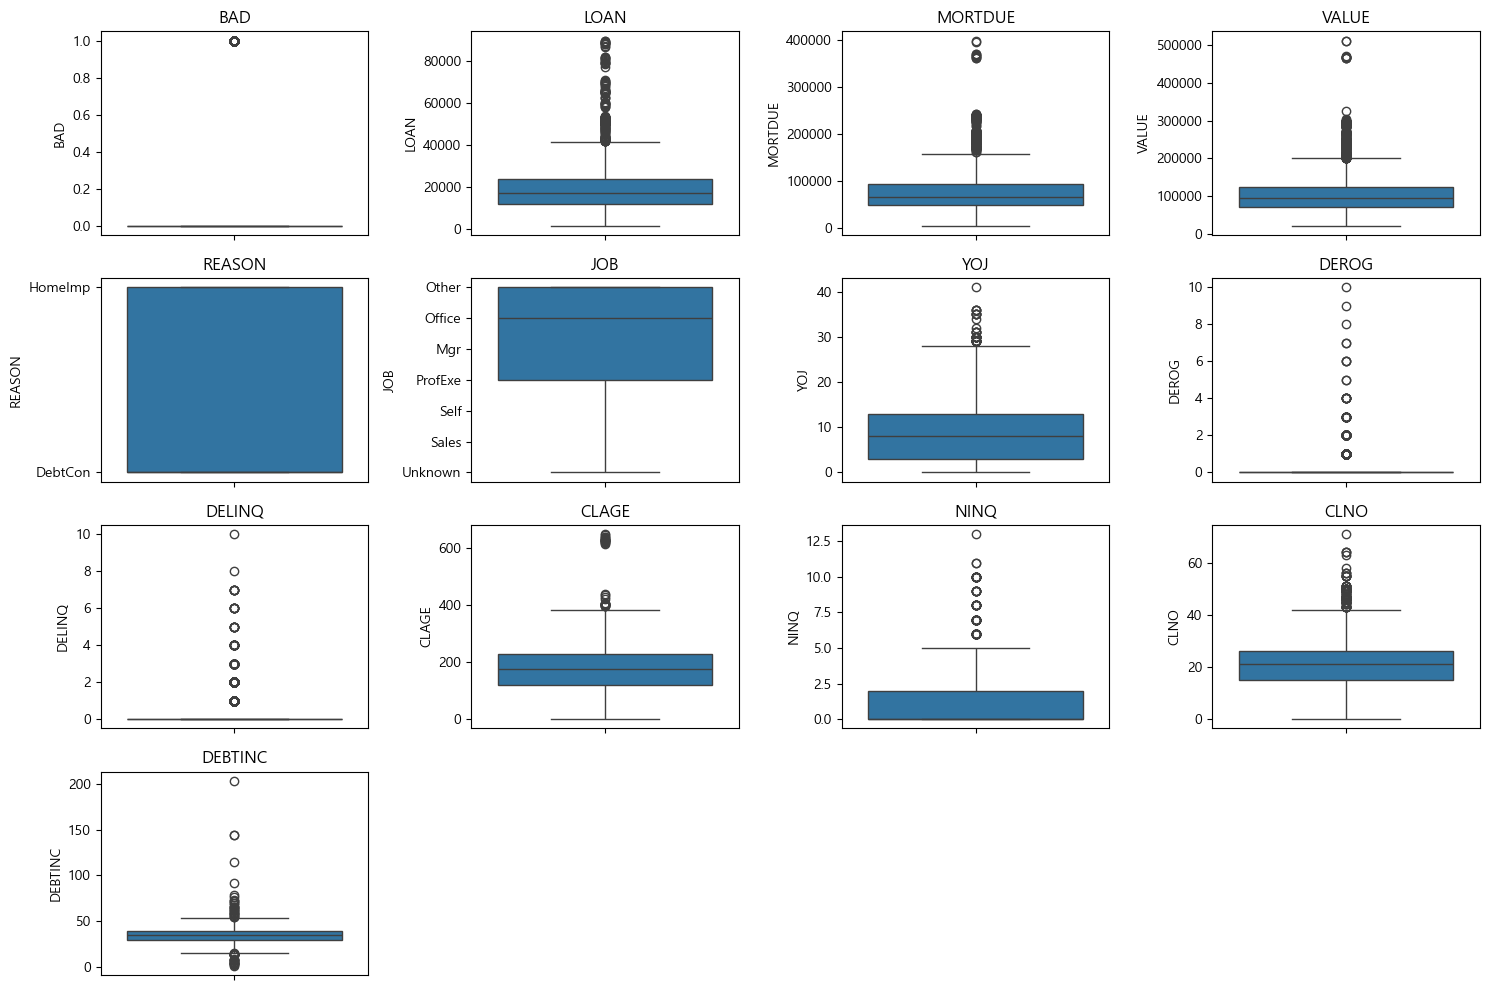

In [29]:
# 이상치 확인
# 그래프 크기 설정
plt.figure(figsize=(15, 10))

# 각 컬럼에 대한 상자 그림 생성
for i, column in enumerate(df.columns, 1):
    plt.subplot(4, 4, i)  # 4x4 그리드에 그래프 배치
    sns.boxplot(data=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()


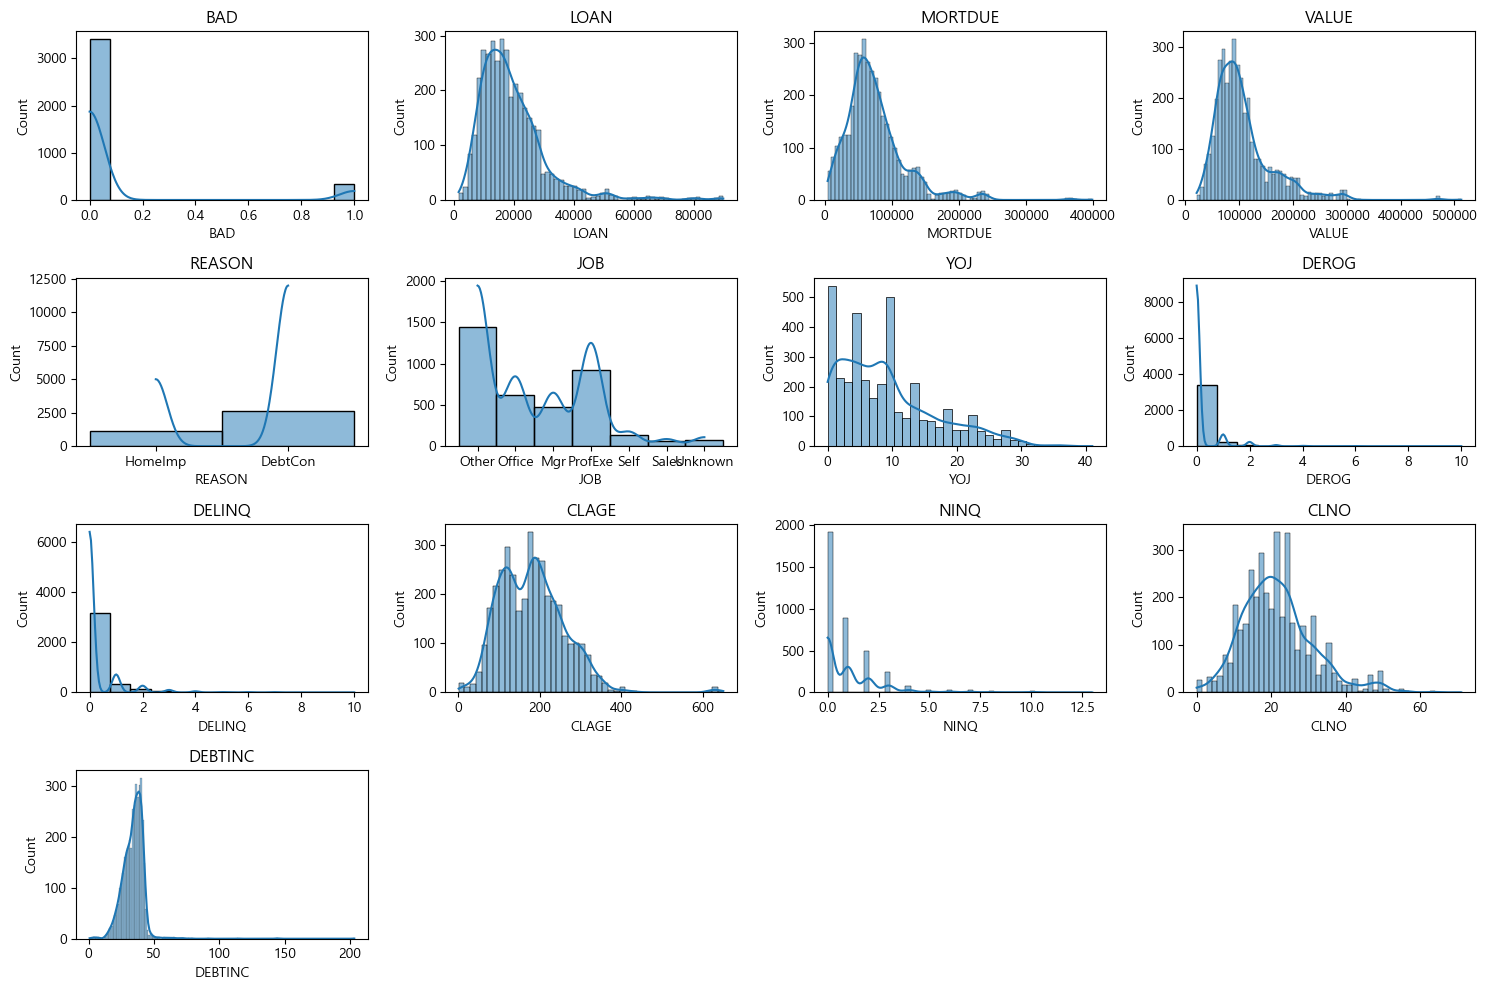

In [46]:
# 이상치 확인
# 그래프 크기 설정
plt.figure(figsize=(15, 10))

# 각 컬럼에 대한 상자 그림 생성
for i, column in enumerate(df.columns, 1):
    plt.subplot(4, 4, i)  # 4x4 그리드에 그래프 배치
    sns.histplot(data=df[column],kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()


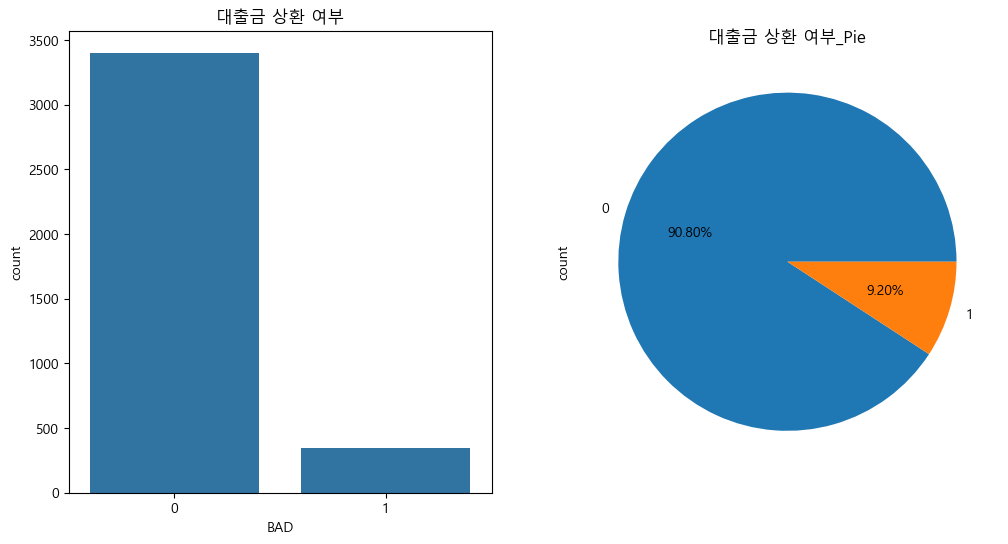

In [57]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
sns.countplot(x='BAD',data=df,ax=axs[0])
axs[0].set_title("대출금 상환 여부")
# 대출금 상환 여부, 0은 상환, 1은 미상환
df.BAD.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("대출금 상환 여부_Pie")
plt.show()

In [61]:
# ANOVA 검정을 할 것이다.
# 수행 하기 전 몇가지 가정을 기반으로 해야한다.

# 1.기술 통계 : 각 그룹의 평균,표준편차 등을 계산
# 2. 박스플롯 및 히스토그램: 각 데이터 분포를 시각화하여 이상치 및 분포 형태를 확인


# 1. 데이터 탐색 및 시각화
print(df.groupby('JOB')['BAD'].describe().T)

JOB           Mgr      Office        Other     ProfExe      Sales        Self  \
count  477.000000  623.000000  1444.000000  929.000000  64.000000  130.000000   
mean     0.111111    0.070626     0.104571    0.068891   0.250000    0.123077   
std      0.314600    0.256405     0.306105    0.253406   0.436436    0.329796   
min      0.000000    0.000000     0.000000    0.000000   0.000000    0.000000   
25%      0.000000    0.000000     0.000000    0.000000   0.000000    0.000000   
50%      0.000000    0.000000     0.000000    0.000000   0.000000    0.000000   
75%      0.000000    0.000000     0.000000    0.000000   0.250000    0.000000   
max      1.000000    1.000000     1.000000    1.000000   1.000000    1.000000   

JOB      Unknown  
count  81.000000  
mean    0.012346  
std     0.111111  
min     0.000000  
25%     0.000000  
50%     0.000000  
75%     0.000000  
max     1.000000  


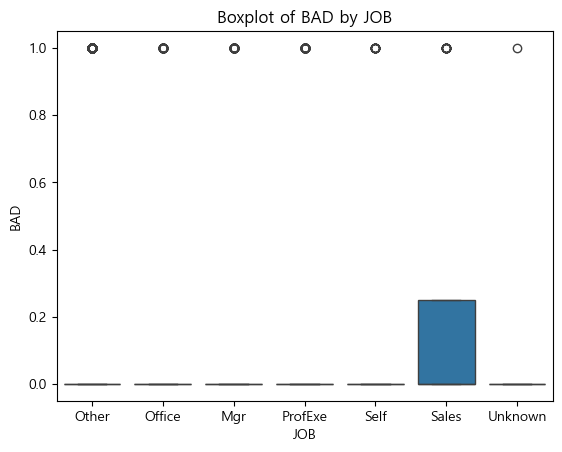

In [42]:

sns.boxplot(x='JOB', y='BAD', data=df)
plt.title('Boxplot of BAD by JOB')
plt.show()

In [ ]:
# 대출상환여부(BAD)에 따라 대출 금액(LOAN)의 차이를 확인하기 위한 검정 -> 2 sample t test
# 대출상환여부(BAD)에 따라 현재 주택담보 대출 잔액(MORTDUE)의 차이를 확인하기 위한 검정 -> 2 sample t test
# 대출상환여부(BAD)에 따라 주택의 현재 가치(VALUE)의 차이를 확인하기 위한 검정 -> 2 sample t test
# 대출상환여부(BAD)에 따라 대출 사유(REASON)의 차이를 확인하기 위한 검정 -> ANOVA
# 대출상환여부(BAD)에 따라 직업(JOB)의 차이를 확인하기 위한 검정 -> ANOVA
# 대출상환여부(BAD)에 따라 현재 직장에서의 근무 연수(YOJ)의 차이를 확인하기 위한 검정 -> 2 sample t test

In [73]:
df['JOB'].value_counts()

JOB
Other      1444
ProfExe     929
Office      623
Mgr         477
Self        130
Unknown      81
Sales        64
Name: count, dtype: int64

In [85]:
import pandas as pd
from scipy.stats import chi2_contingency

observed_df = df.set_index('JOB')

# 카이제곱 독립성 검정 수행
chi2_stat, p_value, dof, expected = chi2_contingency(observed_df)

# 결과 출력
print(f"카이제곱 통계량: {chi2_stat}")
print(f"P-값: {p_value}")
print(f"자유도: {dof}")
print("기대 빈도:")
print(expected)

# 유의 수준 설정 (예: 0.05)
alpha = 0.05

# 결과 해석
if p_value < alpha:
    print("귀무 가설을 기각합니다. JOB과 BAD 간의 관계가 통계적으로 유의미합니다.")
else:
    print("귀무 가설을 기각할 수 없습니다. JOB과 BAD 간의 관계가 통계적으로 유의미하지 않습니다.")

TypeError: '<' not supported between instances of 'str' and 'int'

### 프로젝트 Tip
- 1) 개선안 ~~가 필요하다 라고 결론을 내야함
- 2) 개선안 도출은 어떻게하겠다 라고하고 구체화된 이미지를 도출해야한다.
- 3) 목표를 1개로 정해서하면 사고력이 줄기 때문에 개선안을 딱 정해서 하면 사고력이 제한이 된다. 폭 넓게 분석을해서 여러가지 개선안을 찾는 것이 좋다

- 4) 추진배경 : 당사회사가 이러한 상황들이라 현재 이러한 것을 해결해야겠다. 등의 형식으로 작성
- 5) 분석 결과에서 바로 개선안 도출을 하는 것이 이해하기 좋다.
- 6) 그 후 개선안 도출에 최종 정리를하는 것이다.파악